In [1]:
import math
import torch
import pickle
import torch.cuda
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision.datasets as dsets
import os
from utils.BBBConvmodel import BBBAlexNet, BBBLeNet, BBB3Conv3FC, BBBVGG16, BBBVGG19
from utils.BBBlayers import GaussianVariationalInference
import numpy as np
from scipy.stats import norm, cauchy
cuda = torch.cuda.is_available()
import pandas as pd
from matplotlib import pyplot as plt
import scipy
from scipy import stats
from scipy.optimize import minimize
import math
import io
import gzip
import bz2
import lzma

In [2]:
batch_size = 64
lr = 0.001
dataset = 'CIFAR-10'
network = 'vgg19'
epoch = 100
net = BBBLeNet
num_samples = 10
beta_type = "Blundell"

In [3]:
# dimensions of input and output
if dataset == 'MNIST':    # train with MNIST
    outputs = 10
    inputs = 1
elif dataset == 'CIFAR-10':  # train with CIFAR-10
    outputs = 10
    inputs = 3
elif dataset == 'CIFAR-100':    # train with CIFAR-100
    outputs = 100
    inputs = 3

if net == BBBLeNet or BBB3Conv3FC:
    resize = 32
elif net == BBBAlexNet:
    resize = 227

if network == "lenet":
    if epoch != 50:
        model = torch.load("../results/{}_b{}_lr{}epoch{}_{}.pth".format(network, batch_size, lr, epoch, dataset))
    else:
        model = torch.load("../results/{}_b{}_lr{}_{}.pth".format(network, batch_size, lr, dataset))
elif network == "vgg19":
    model = BBBVGG19(outputs, inputs)
    model.load_state_dict(torch.load("../results/NormAddbiasVarBias_CIFAR-10_modelvgg19_withbias_param_epoch100_lr0.001_bs64.pkl"))

In [4]:
'''
LOADING DATASET
'''

if dataset == 'MNIST':
    transform = transforms.Compose([transforms.Resize((resize, resize)), transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))])
    train_dataset = dsets.MNIST(root="data", download=True, transform=transform)
    val_dataset = dsets.MNIST(root="data", download=True, train=False, transform=transform)

elif dataset == 'CIFAR-100':
    transform = transforms.Compose([transforms.Resize((resize, resize)), transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    train_dataset = dsets.CIFAR100(root="data", download=True, transform=transform)
    val_dataset = dsets.CIFAR100(root='data', download=True, train=False, transform=transform)

elif dataset == 'CIFAR-10':
    transform = transforms.Compose([transforms.Resize((resize, resize)), transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    train_dataset = dsets.CIFAR10(root="data", download=True, transform=transform)
    val_dataset = dsets.CIFAR10(root='data', download=True, train=False, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
loader_val = data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [6]:
model.state_dict().keys()

odict_keys(['conv1.qw_mean', 'conv1.qw_logvar', 'conv1.qb_mean', 'conv1.qb_logvar', 'conv1.conv_qw_mean', 'conv1.conv_qw_si', 'conv1.log_alpha', 'conv1a.1.weight', 'conv1a.1.bias', 'conv1a.1.running_mean', 'conv1a.1.running_var', 'conv1a.1.num_batches_tracked', 'conv2.qw_mean', 'conv2.qw_logvar', 'conv2.qb_mean', 'conv2.qb_logvar', 'conv2.conv_qw_mean', 'conv2.conv_qw_si', 'conv2.log_alpha', 'conv2a.1.weight', 'conv2a.1.bias', 'conv2a.1.running_mean', 'conv2a.1.running_var', 'conv2a.1.num_batches_tracked', 'conv3.qw_mean', 'conv3.qw_logvar', 'conv3.qb_mean', 'conv3.qb_logvar', 'conv3.conv_qw_mean', 'conv3.conv_qw_si', 'conv3.log_alpha', 'conv3a.1.weight', 'conv3a.1.bias', 'conv3a.1.running_mean', 'conv3a.1.running_var', 'conv3a.1.num_batches_tracked', 'conv4.qw_mean', 'conv4.qw_logvar', 'conv4.qb_mean', 'conv4.qb_logvar', 'conv4.conv_qw_mean', 'conv4.conv_qw_si', 'conv4.log_alpha', 'conv4a.1.weight', 'conv4a.1.bias', 'conv4a.1.running_mean', 'conv4a.1.running_var', 'conv4a.1.num_batche

 # 合并weights

In [14]:
model = model.cpu()
if network == "lenet" or network == "lenet5":
    depths = [0, 3, 7, 9, 11]
elif network == "vgg16":
    depths = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 27, 30, 33]
elif network == "vgg19":
    depths = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26,28,30,33,36,39] # VGG19
w_name = ['layers.{}.qw_'.format(depth) for depth in depths]
b_name = ['layers.{}.qb_'.format(depth) for depth in depths]
whole_w = []
for (i, j) in zip(w_name, b_name):
    whole_w.append(model.state_dict()['{}mean'.format(i)].numpy().ravel())
    whole_w.append(model.state_dict()['{}mean'.format(j)].numpy().ravel())
whole_w = np.concatenate(whole_w)
len(whole_w)
len(whole_w[np.abs(whole_w) <= 1e-2])

6052045

 # 神经网络精度计算函数

In [15]:
vi = GaussianVariationalInference(torch.nn.CrossEntropyLoss())

def run_epoch(loader, epoch, is_training=False, model=model):
    m = math.ceil(len(loader.dataset) / loader.batch_size)

    accuracies = []
    likelihoods = []
    kls = []
    losses = []

    for i, (images, labels) in enumerate(loader):
        # # Repeat samples (Casper's trick)
        # x = images.view(-1, inputs, resize, resize).repeat(num_samples, 1, 1, 1)
        # y = labels.repeat(num_samples)
        x = images.view(-1, inputs, resize, resize)
        y = labels
        if cuda:
            x = x.cuda()
            y = y.cuda()

        if beta_type == "Blundell":
            beta = 2 ** (m - (i + 1)) / (2 ** m - 1)
        elif beta_type == "Soenderby":
            beta = min(epoch / (num_epochs//4), 1)
        elif beta_type == "Standard":
            beta = 1 / m
        else:
            beta = 0

        logits, kl = model.probforward(x)
        loss = vi(logits, y, kl, beta)
        ll = -loss.data.mean() + beta*kl.data.mean()

        if is_training:
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

        _, predicted = logits.max(1)
        accuracy = (predicted.data.cpu() == y.cpu()).float().mean()

        accuracies.append(accuracy)
        losses.append(loss.data.mean())
        kls.append(beta*kl.data.mean())
        likelihoods.append(ll)

    diagnostics = {'loss': sum(losses)/len(losses),
                   'acc': sum(accuracies)/len(accuracies),
                   'kl': sum(kls)/len(kls),
                   'likelihood': sum(likelihoods)/len(likelihoods)}

    return diagnostics

In [16]:
model = model.cuda()
diagnostics_val = run_epoch(loader_val, epoch=1)

conv torch.Size([64, 64, 34, 34])
x torch.Size([64, 64, 34, 34])
conv torch.Size([64, 64, 36, 36])
x torch.Size([64, 64, 18, 18])
conv torch.Size([64, 128, 18, 18])
x torch.Size([64, 128, 18, 18])
conv torch.Size([64, 128, 18, 18])
x torch.Size([64, 128, 9, 9])
conv torch.Size([64, 256, 9, 9])
x torch.Size([64, 256, 9, 9])
conv torch.Size([64, 256, 9, 9])
x torch.Size([64, 256, 9, 9])
conv torch.Size([64, 256, 9, 9])
x torch.Size([64, 256, 9, 9])
conv torch.Size([64, 256, 9, 9])
x torch.Size([64, 256, 4, 4])
conv torch.Size([64, 512, 4, 4])
x torch.Size([64, 512, 4, 4])
conv torch.Size([64, 512, 4, 4])
x torch.Size([64, 512, 4, 4])
conv torch.Size([64, 512, 4, 4])
x torch.Size([64, 512, 4, 4])
conv torch.Size([64, 512, 4, 4])
x torch.Size([64, 512, 2, 2])
conv torch.Size([64, 512, 2, 2])
x torch.Size([64, 512, 2, 2])
conv torch.Size([64, 512, 2, 2])
x torch.Size([64, 512, 2, 2])
conv torch.Size([64, 512, 2, 2])
x torch.Size([64, 512, 2, 2])
conv torch.Size([64, 512, 2, 2])
x torch.Size

In [17]:
diagnostics_val

{'loss': tensor(161822.9844, device='cuda:0'),
 'acc': tensor(0.7116),
 'kl': tensor(161822.4844, device='cuda:0'),
 'likelihood': tensor(-0.8732, device='cuda:0')}

In [18]:
def evaluate(loader, cpr_model, epoch=1):
    m = math.ceil(len(loader.dataset) / loader.batch_size)

    accuracies = []

    for i, (images, labels) in enumerate(loader):
        # # Repeat samples (Casper's trick)
        # x = images.view(-1, inputs, resize, resize).repeat(num_samples, 1, 1, 1)
        # y = labels.repeat(num_samples)

        x = images.view(-1, inputs, resize, resize)
        y = labels

        if cuda:
            x = x.cuda()
            y = y.cuda()

        logits = cpr_model(x)
        _, predicted = torch.max(logits.data, 1)
        accuracy = (predicted.data.cpu() == y.cpu()).float().mean()

        accuracies.append(accuracy)

    diagnostics = {'acc': sum(accuracies)/len(accuracies)}

    return diagnostics

 把BNN的weights套进确定性网络，测试精度

In [20]:
model = model.cpu()
uncompressed_list = []
for depth in depths:
    i = 'layers.{}.qw_'.format(depth)
    j = 'layers.{}.qb_'.format(depth)
    # w
    vecs_u1 = model.state_dict()['{}mean'.format(i)]
    uncompressed_list.append(vecs_u1)
    # b
    vecs_u2 = model.state_dict()['{}mean'.format(j)]
    uncompressed_list.append(vecs_u2)
    #如果是vgg，还要把normalization层的参数加入
    if network == "vgg19" and depth < 33:
        para_dict = model.state_dict()
        temp2 = para_dict['layers.{}.1.weight'.format(depth+1)]
        uncompressed_list.append(temp2)
        temp3 = para_dict['layers.{}.1.bias'.format(depth+1)]
        uncompressed_list.append(temp3)
        temp4 = para_dict['layers.{}.1.running_mean'.format(depth+1)]
        uncompressed_list.append(temp4)
        temp5 = para_dict['layers.{}.1.running_var'.format(depth+1)]
        uncompressed_list.append(temp5)
        temp6 = para_dict['layers.{}.1.num_batches_tracked'.format(depth+1)]
        uncompressed_list.append(temp6)

if network == "lenet":
    # lenet
    from model import lenet
    uncpr_model=lenet(inputs)
elif network == "vgg16":
    from model import VGG16
    uncpr_model = VGG16(inputs)
elif network == "vgg19":
    from model import VGG19
    uncpr_model=VGG19(inputs = inputs,outputs=outputs)
name_uncpr=uncpr_model.state_dict().keys()
uncpr_state_dict = dict(zip(name_uncpr, uncompressed_list))
uncpr_model.load_state_dict(uncpr_state_dict)
# 用压缩后的模型计算loss，acc等
uncpr_model = uncpr_model.cuda()
diagnostics_uncpr_val = evaluate(loader_val, cpr_model=uncpr_model)

In [14]:
para_dict = model.state_dict()
uncompressed_list = []
for i in depths:
    for j in ['w','b']:
        vecs_u = model.state_dict()['layers.{}.q{}_mean'.format(i,j)].numpy()        
        uncompressed_list.append(vecs_u)
    if i < 33:
        temp2 = para_dict['layers.{}.1.weight'.format(i+1)]
        uncompressed_list.append(temp2)
        temp3 = para_dict['layers.{}.1.bias'.format(i+1)]
        uncompressed_list.append(temp3)
        temp4 = para_dict['layers.{}.1.running_mean'.format(i+1)]
        uncompressed_list.append(temp4)
        temp5 = para_dict['layers.{}.1.running_var'.format(i+1)]
        uncompressed_list.append(temp5)
        temp6 = para_dict['layers.{}.1.num_batches_tracked'.format(i+1)]
        uncompressed_list.append(temp6)

from model import VGG19
cpr_model=VGG19(inputs = inputs,outputs=outputs)
name_uncpr=cpr_model.state_dict().keys()
cpr_state_dict = dict(zip(name_uncpr, uncompressed_list))
for i, j in zip(para_dict, cpr_state_dict):
    print(i)
    print(j)

conv1.qw_mean
features.0.weight
conv1.qw_logvar
features.0.bias
conv1.qb_mean
features.2.weight
conv1.qb_logvar
features.2.bias
conv1.conv_qw_mean
features.2.running_mean
conv1.conv_qw_si
features.2.running_var
conv1.log_alpha
features.2.num_batches_tracked
conv1a.1.weight
features.3.weight
conv1a.1.bias
features.3.bias
conv1a.1.running_mean
features.5.weight
conv1a.1.running_var
features.5.bias
conv1a.1.num_batches_tracked
features.5.running_mean
conv2.qw_mean
features.5.running_var
conv2.qw_logvar
features.5.num_batches_tracked
conv2.qb_mean
features.7.weight
conv2.qb_logvar
features.7.bias
conv2.conv_qw_mean
features.9.weight
conv2.conv_qw_si
features.9.bias
conv2.log_alpha
features.9.running_mean
conv2a.1.weight
features.9.running_var
conv2a.1.bias
features.9.num_batches_tracked
conv2a.1.running_mean
features.10.weight
conv2a.1.running_var
features.10.bias
conv2a.1.num_batches_tracked
features.12.weight
conv3.qw_mean
features.12.bias
conv3.qw_logvar
features.12.running_mean
conv3.q

In [15]:
para_dict = model.state_dict()
uncompressed_list = []
for i in depths:
    for j in ['w','b']:
        vecs_u = model.state_dict()['layers.{}.q{}_mean'.format(i,j)].numpy()        
        uncompressed_list.append(vecs_u)
    if i < 33:
        temp2 = para_dict['layers.{}.1.weight'.format(i+1)]
        uncompressed_list.append(temp2)
        temp3 = para_dict['layers.{}.1.bias'.format(i+1)]
        uncompressed_list.append(temp3)
        temp4 = para_dict['layers.{}.1.running_mean'.format(i+1)]
        uncompressed_list.append(temp4)
        temp5 = para_dict['layers.{}.1.running_var'.format(i+1)]
        uncompressed_list.append(temp5)
        temp6 = para_dict['layers.{}.1.num_batches_tracked'.format(i+1)]
        uncompressed_list.append(temp6)

from model import VGG19
cpr_model=VGG19(inputs = inputs,outputs=outputs)
name_uncpr=cpr_model.state_dict().keys()
cpr_state_dict = dict(zip(name_uncpr, uncompressed_list))
for i, j in zip(cpr_model.state_dict(), cpr_state_dict):
    print(i)
    print(j)

features.0.weight
features.0.weight
features.0.bias
features.0.bias
features.2.weight
features.2.weight
features.2.bias
features.2.bias
features.2.running_mean
features.2.running_mean
features.2.running_var
features.2.running_var
features.2.num_batches_tracked
features.2.num_batches_tracked
features.3.weight
features.3.weight
features.3.bias
features.3.bias
features.5.weight
features.5.weight
features.5.bias
features.5.bias
features.5.running_mean
features.5.running_mean
features.5.running_var
features.5.running_var
features.5.num_batches_tracked
features.5.num_batches_tracked
features.7.weight
features.7.weight
features.7.bias
features.7.bias
features.9.weight
features.9.weight
features.9.bias
features.9.bias
features.9.running_mean
features.9.running_mean
features.9.running_var
features.9.running_var
features.9.num_batches_tracked
features.9.num_batches_tracked
features.10.weight
features.10.weight
features.10.bias
features.10.bias
features.12.weight
features.12.weight
features.12.bi

In [16]:
para_dict = model.state_dict()
uncompressed_list = []
for i in depths:
    for j in ['w','b']:
        vecs_u = model.state_dict()['layers.{}.q{}_mean'.format(i,j)].numpy()        
        uncompressed_list.append(vecs_u)
    if i < 33:
        temp2 = para_dict['layers.{}.1.weight'.format(i+1)]
        uncompressed_list.append(temp2)
        temp3 = para_dict['layers.{}.1.bias'.format(i+1)]
        uncompressed_list.append(temp3)
        temp4 = para_dict['layers.{}.1.running_mean'.format(i+1)]
        uncompressed_list.append(temp4)
        temp5 = para_dict['layers.{}.1.running_var'.format(i+1)]
        uncompressed_list.append(temp5)
        temp6 = para_dict['layers.{}.1.num_batches_tracked'.format(i+1)]
        uncompressed_list.append(temp6)

from model import VGG19
cpr_model=VGG19(inputs = inputs,outputs=outputs)
name_uncpr=cpr_model.state_dict().keys()
cpr_state_dict = dict(zip(name_uncpr, uncompressed_list))
for i, j in zip(cpr_model.state_dict().values(), cpr_state_dict.values()):
    print(i)
    print(j)

tensor([[[[ 0.1503, -0.1079, -0.0371],
          [ 0.1788, -0.0724, -0.0035],
          [-0.0495, -0.0817, -0.0493]],

         [[ 0.0872, -0.1770, -0.0401],
          [-0.0608,  0.0270,  0.1537],
          [-0.0594, -0.1046,  0.0805]],

         [[-0.0306,  0.0042, -0.0816],
          [-0.1342,  0.0741, -0.1280],
          [-0.1654, -0.1572, -0.0292]]],


        [[[-0.1593,  0.1858,  0.1750],
          [-0.1582, -0.1063,  0.0116],
          [-0.1864, -0.0917, -0.0745]],

         [[-0.0912,  0.0087,  0.1774],
          [ 0.1440,  0.1782, -0.1443],
          [ 0.1576,  0.0609,  0.0781]],

         [[ 0.0820,  0.0762,  0.1113],
          [-0.0018,  0.1043,  0.1435],
          [-0.1544, -0.1583, -0.1608]]],


        [[[-0.0815, -0.1403, -0.1821],
          [ 0.1404, -0.1263,  0.0847],
          [-0.1675, -0.1420, -0.1812]],

         [[-0.1274,  0.0662, -0.0874],
          [-0.0941,  0.1614,  0.1081],
          [-0.1159, -0.1367,  0.0130]],

         [[ 0.0645, -0.1717, -0.1384],
     

In [17]:
para_dict = model.state_dict()
uncompressed_list = []
for i in depths:
    for j in ['w','b']:
        vecs_u = model.state_dict()['layers.{}.q{}_mean'.format(i,j)].numpy()        
        uncompressed_list.append(vecs_u)
    if i < 33:
        temp2 = para_dict['layers.{}.1.weight'.format(i+1)]
        uncompressed_list.append(temp2)
        temp3 = para_dict['layers.{}.1.bias'.format(i+1)]
        uncompressed_list.append(temp3)
        temp4 = para_dict['layers.{}.1.running_mean'.format(i+1)]
        uncompressed_list.append(temp4)
        temp5 = para_dict['layers.{}.1.running_var'.format(i+1)]
        uncompressed_list.append(temp5)
        temp6 = para_dict['layers.{}.1.num_batches_tracked'.format(i+1)]
        uncompressed_list.append(temp6)

from model import VGG19
cpr_model=VGG19(inputs = inputs,outputs=outputs)
name_uncpr=cpr_model.state_dict().keys()
cpr_state_dict = dict(zip(name_uncpr, uncompressed_list))
for i, j in zip(cpr_model.state_dict().values(), cpr_state_dict.values()):
    print(i.shape)
    print(j.shape)

torch.Size([64, 3, 3, 3])
(64, 3, 3, 3)
torch.Size([64])
(64,)
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([])
torch.Size([])
torch.Size([64, 64, 3, 3])
(64, 64, 3, 3)
torch.Size([64])
(64,)
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([])
torch.Size([])
torch.Size([128, 64, 3, 3])
(128, 64, 3, 3)
torch.Size([128])
(128,)
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([])
torch.Size([])
torch.Size([128, 128, 3, 3])
(128, 128, 3, 3)
torch.Size([128])
(128,)
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([])
torch.Size([])
torch.Size([256, 128, 3, 3])
(256, 128, 3, 3)
torch.

In [18]:
model = model.cpu()
if network != "vgg19":
    uncompressed_list = []
    for (i, j) in zip(w_name, b_name):
        # w
        vecs_u1 = model.state_dict()['{}mean'.format(i)]
        uncompressed_list.append(vecs_u1)
        # b
        vecs_u2 = model.state_dict()['{}mean'.format(j)]
        uncompressed_list.append(vecs_u2)

    if network == "lenet":
        # lenet
        from model import lenet
        cpr_model=lenet(inputs)
    elif network == "vgg16":
        from model import VGG16
        cpr_model = VGG16(inputs)
    name_uncpr=cpr_model.state_dict().keys()
    uncpr_state_dict = dict(zip(name_uncpr, uncompressed_list))
    cpr_model.load_state_dict(uncpr_state_dict)
    # 用压缩后的模型计算loss，acc等
    cpr_model = cpr_model.cuda()
    diagnostics_uncpr_val = evaluate(loader_val, cpr_model=cpr_model)

else:
    para_dict = model.state_dict()
    uncompressed_list = []
    for i in depths:
        for j in ['w','b']:
            vecs_u = model.state_dict()['layers.{}.q{}_mean'.format(i,j)]
            uncompressed_list.append(vecs_u)
        if i < 33:
            temp2 = para_dict['layers.{}.1.weight'.format(i+1)]
            uncompressed_list.append(temp2)
            temp3 = para_dict['layers.{}.1.bias'.format(i+1)]
            uncompressed_list.append(temp3)
            temp4 = para_dict['layers.{}.1.running_mean'.format(i+1)]
            uncompressed_list.append(temp4)
            temp5 = para_dict['layers.{}.1.running_var'.format(i+1)]
            uncompressed_list.append(temp5)
            temp6 = para_dict['layers.{}.1.num_batches_tracked'.format(i+1)]
            uncompressed_list.append(temp6)

    from model import VGG19
    cpr_model=VGG19(inputs = inputs,outputs=outputs)
    name_uncpr=cpr_model.state_dict().keys()
    cpr_state_dict = dict(zip(name_uncpr, uncompressed_list))
    cpr_model.load_state_dict(cpr_state_dict)
    cpr_model = cpr_model.cuda()
    diagnostics_uncpr_val = evaluate(loader_val, cpr_model=cpr_model)

In [19]:
diagnostics_uncpr_val

{'acc': tensor(0.6865)}

In [20]:
mrrs_and_bitlengths_list = []
# for method in ["gaussian", "gg", "gmm", "cauchy"]:
for method in ["gaussian"]:

    # # 用不同的lambda和N压缩

    # ## global

    def compress_coordinates(means, stds, lamb, bitlengths, codepoints):
        # N = len(means.ravel()) = len(stds.ravel())
        # C = len(codepoints)
        optima = np.empty_like(means)
        optima_lengths = np.empty_like(means, dtype=int)
        for i in range(0, 10000000, 100000):
            if i % 100000 == 0:
                print(i / 1000000)
            squared_errors = (codepoints[np.newaxis, :] - means.ravel()[i:i+100000, np.newaxis])**2
                # shape (N, C)
            weighted_penalties = (2 * lamb) * stds.ravel()[i:i+100000, np.newaxis]**2 * bitlengths[np.newaxis, :]
                # shape (N, C)
            optima_idxs = np.argmin(squared_errors + weighted_penalties, axis=1)
            optima.ravel()[i:i+100000] = codepoints[optima_idxs]
            optima_lengths.ravel()[i:i+100000] = bitlengths[optima_idxs]
        return optima, optima_lengths

    if method == "gaussian":
        # gaussian
        empirical_mean = np.mean(whole_w)
        empirical_std = np.std(whole_w)

    elif method == "gg":
        # generalized gaussian
        def generalized_gaussian(params, data):
            beta, mu, alpha = params
            n = len(data)
            # log_likelihood = -n*np.log(2*alpha*math.gamma(1/beta)) - np.sum(np.abs((data - mu)/(np.sqrt(2)*alpha))**beta)
            log_likelihood = n*(np.log(beta)-np.log(2)-np.log(alpha)-np.log(math.gamma(1/beta)))-np.sum((np.abs(data - mu)/alpha)**beta)
            return -log_likelihood

        def estimate_generalized_gaussian_parameters(data):
            # Initial parameter guess
            initial_params = [1, np.mean(data), np.std(data)]

            # Define the optimization function
            optimization_func = lambda params: generalized_gaussian(params, data)

            # Perform the optimization
            result = minimize(optimization_func, initial_params, method='Nelder-Mead')

            # Extract the optimized parameters
            beta, mu, alpha = result.x

            return beta, mu, alpha
        beta_est, mu_est, alpha_est = estimate_generalized_gaussian_parameters(whole_w)

        def log_GGD_pdf (mu,alpha,beta,x):
            return np.log(beta)-np.log(2)-np.log(alpha)-np.log(math.gamma(1/beta))-np.sum(np.abs((x - mu)/alpha)**beta)
        def quantile_GGD(alpha,beta,mu,p):
            return np.sign(p-0.5)*((alpha**beta)*stats.gamma.ppf(2*np.abs(p-0.5),1/beta))**(1/beta)+mu
    elif method == "gmm":
        import random
        from sklearn.mixture import GaussianMixture
        import scipy.optimize as optimize
        # gmm
        # 设置随机种子
        seed = 42
        np.random.seed(seed)
        random.seed(seed)

        # 定义要尝试的n_components值
        n_min = 2
        n_components_range = range(n_min, 10)

        # 初始化信息准则列表
        # aic_scores = []
        bic_scores = []

        # 计算每个n_components值上的信息准则值
        for n_components in n_components_range:
            gmm = GaussianMixture(n_components=n_components)
            gmm.fit(whole_w.reshape(-1,1))
            # aic_scores.append(gmm.aic(whole_w.reshape(-1,1)))
            bic_scores.append(gmm.bic(whole_w.reshape(-1,1)))

        # 选择具有最小信息准则值的n_components值
        # best_n_components_aic = np.argmin(aic_scores) + n_min
        best_n_components_bic = np.argmin(bic_scores) + n_min

        # print("Best n_components (AIC):", best_n_components_aic)
        print("Best n_components (BIC):", best_n_components_bic)

        gmm = GaussianMixture(n_components=best_n_components_bic)
        gmm.fit(whole_w.reshape(-1,1))

        # 获取每个混合分量的参数（均值、标准差、权重）
        means = gmm.means_.squeeze()
        covs = gmm.covariances_.squeeze()  #注意covs是方差，不是标准差
        pis = gmm.weights_.squeeze()
        def F(x, w, u, s):
            return sum(w * norm.cdf(x, loc=u, scale=s))

        def F_inv(p, w, u, s, br=(-1000, 1000)):
            G = lambda x: F(x, w, u, s) - p
            result = optimize.root_scalar(G, bracket=br)
            return result.root
    elif method == "cauchy":
        # cauchy
        cauchy_loc, cauchy_scale = cauchy.fit(whole_w)

    from collections import Counter
    def empirical_entropy(values):
        counts = np.array(list(Counter(values.ravel()).values()))
        total_counts = counts.sum()
        return total_counts * np.log2(total_counts) - counts.dot(np.log2(counts))

    model = model.cpu()
    def compress_model(lamb, strategy, max_codepoint_length=10):
        compressed_add_len = 0
        compressed_list = []
        quantized = []
        for (i, j) in zip(w_name, b_name):
            # w
            vecs_u1 = model.state_dict()['{}mean'.format(i)].numpy()
            stds_u1 = np.exp(model.state_dict()['{}logvar'.format(i)].numpy())
            # b
            vecs_u2 = model.state_dict()['{}mean'.format(j)].numpy()
            stds_u2 = np.exp(model.state_dict()['{}logvar'.format(j)].numpy())

            if strategy == "global":
                if method == "gaussian":
                    global empirical_mean, empirical_std
                    codepoints_and_lengths = [
                        (scipy.stats.norm.ppf(codepoint_xi, loc=empirical_mean, scale=empirical_std), length)
                        for length in range(max_codepoint_length+1)
                        for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
                    ]
                elif method == "gg":
                    global alpha_est,beta_est,mu_est
                    codepoints_and_lengths = [
                        (quantile_GGD(alpha_est,beta_est,mu_est,codepoint_xi), length)
                        for length in range(max_codepoint_length+1)
                        for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
                    ]
                elif method == "gmm":
                    global pis, means, covs
                    codepoints_and_lengths = [
                        (F_inv(codepoint_xi, pis, means, np.sqrt(covs)), length)
                        for length in range(max_codepoint_length+1)
                        for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
                    ]
                elif method == "cauchy":
                    global cauchy_loc, cauchy_scale
                    codepoints_and_lengths = [
                        (scipy.stats.cauchy.ppf(codepoint_xi, loc=cauchy_loc, scale=cauchy_scale), length)
                        for length in range(max_codepoint_length+1)
                        for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
                    ]
                else:
                    print('method not found!')
                    break
            if strategy == "layer-wise":
                # 先把w和b合并在一起再拟合
                vecs_u = np.concatenate([vecs_u1.ravel(), vecs_u2.ravel()])
                if method == "gaussian":
                    empirical_mean = np.mean(vecs_u)
                    empirical_std = np.std(vecs_u)
                    codepoints_and_lengths = [
                        (scipy.stats.norm.ppf(codepoint_xi, loc=empirical_mean, scale=empirical_std), length)
                        for length in range(max_codepoint_length+1)
                        for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
                    ]
                elif method == "gg":
                    beta_est, mu_est, alpha_est = estimate_generalized_gaussian_parameters(vecs_u)
                    codepoints_and_lengths = [
                        (quantile_GGD(alpha_est,beta_est,mu_est,codepoint_xi), length)
                        for length in range(max_codepoint_length+1)
                        for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
                    ]
                elif method == "gmm":
                    # 拟合gmm
                    # 定义要尝试的n_components值
                    n_min = 2
                    n_components_range = range(n_min, 6)

                    # 初始化信息准则列表
                    bic_scores = []

                    # 计算每个n_components值上的信息准则值
                    for n_components in n_components_range:
                        gmm = GaussianMixture(n_components=n_components)
                        gmm.fit(vecs_u.reshape(-1,1))
                        # aic_scores.append(gmm.aic(vecs_u.reshape(-1,1)))
                        bic_scores.append(gmm.bic(vecs_u.reshape(-1,1)))

                    # 选择具有最小信息准则值的n_components值
                    # best_n_components_aic = np.argmin(aic_scores) + n_min
                    best_n_components_bic = np.argmin(bic_scores) + n_min

                    # print("Best n_components (AIC):", best_n_components_aic)
                    print("Best n_components (BIC):", best_n_components_bic)

                    gmm = GaussianMixture(n_components=best_n_components_bic)
                    gmm.fit(vecs_u.reshape(-1,1))

                    # 获取每个混合分量的参数（均值、标准差、权重）
                    means = gmm.means_.squeeze()
                    covs = gmm.covariances_.squeeze()  #注意covs是方差，不是标准差
                    pis = gmm.weights_.squeeze()

                    codepoints_and_lengths = [
                        (F_inv(codepoint_xi, pis, means, np.sqrt(covs)), length)
                        for length in range(max_codepoint_length+1)
                        for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
                    ]
                elif method == "cauchy":
                    cauchy_loc, cauchy_scale = cauchy.fit(vecs_u.ravel())
                    codepoints_and_lengths = [
                        (scipy.stats.cauchy.ppf(codepoint_xi, loc=cauchy_loc, scale=cauchy_scale), length)
                        for length in range(max_codepoint_length+1)
                        for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
                    ]
                else:
                    print("method not found!")
                    break
            codepoints = np.array([codepoint for codepoint, _ in codepoints_and_lengths])
            lengths = np.array([length for _, length in codepoints_and_lengths])
            # compress w
            compressed1, cpr_len1 = compress_coordinates(vecs_u1,stds_u1,lamb,lengths,codepoints)
            quantized.append(compressed1.flatten())
            compressed1 = torch.from_numpy(compressed1)
            compressed_list.append(compressed1)
            compressed_add_len += np.sum(cpr_len1)
            # compress b
            compressed2, cpr_len2 = compress_coordinates(vecs_u2,stds_u2,lamb,lengths,codepoints)
            quantized.append(compressed2.flatten())
            compressed2 = torch.from_numpy(compressed2)
            compressed_list.append(compressed2)
            compressed_add_len += np.sum(cpr_len2)

        if network == "lenet":
            # lenet
            from model import lenet
            cpr_model=lenet(inputs)
        elif network == "vgg16":
            from model import VGG16
            cpr_model = VGG16(inputs)
        name_cpr=cpr_model.state_dict().keys()
        cpr_state_dict = dict(zip(name_cpr, compressed_list))
        cpr_model.load_state_dict(cpr_state_dict)
        # 用压缩后的模型计算loss，acc等
        cpr_model = cpr_model.cuda()
        diagnostics_cpr_val = evaluate(loader_val, cpr_model=cpr_model)
        acc = diagnostics_cpr_val['acc'].numpy()
        # 计算compressed_AC_len
        quantized = np.concatenate(quantized)
        # AC coding
        print('  AC coding...')
        compressed_AC_len = empirical_entropy(quantized)
        # compressed_AC_len是最后用AC再编码，compressed_add_len是直接叠加

        # 获取唯一的标签值
        unique_labels = np.unique(quantized)
        # 构建标签映射字典
        label_map = {label: i for i, label in enumerate(unique_labels)}
        # 进行整数编码
        encoded_labels = np.array([label_map[label] for label in quantized])
        encoded_labels = encoded_labels - int(encoded_labels.max()/2)  # 以0为中心分布

        print('  Converting to bytes ...')
        if np.abs(encoded_labels).max() <= 127:
            quantized_bytes = encoded_labels.astype(np.int8)
        else:
            quantized_bytes = encoded_labels.astype(np.int16)

        print('  Gzipping ...')
        buf = io.BytesIO()
        gz = gzip.GzipFile(fileobj=buf, mode="wb", compresslevel=9)
        gz.write(bytes(quantized_bytes.data))
        gz.flush()
        gz.close()
        buf.flush()
        gzip_bitlength = len(buf.getbuffer()) * 8

        print('  Bzip2 ...')
        buf = io.BytesIO()
        bz = bz2.BZ2File(buf, mode="wb", compresslevel=9)
        bz.write(bytes(quantized_bytes.data))
        bz.flush()
        bz.close()
        buf.flush()
        bz2_bitlength = len(buf.getbuffer()) * 8

        print('  Lzma ...')
        buf = io.BytesIO()
        lz = lzma.LZMAFile(buf, mode="wb", preset=9, format=lzma.FORMAT_ALONE)
        lz.write(bytes(quantized_bytes.data))
        lz.flush()
        lz.close()
        buf.flush()
        lzma_bitlength = len(buf.getbuffer()) * 8

        # compressed_AC_len是最后用AC再编码，compressed_add_len是直接叠加
        print("lamb=", lamb, "max_codepoint_length", max_codepoint_length, "strategy=", strategy)
        print("acc=",acc)
        print("compressed_AC_len",compressed_AC_len)
        print("compressed_gzip_len",gzip_bitlength)
        print("compressed_bzip2_len",bz2_bitlength)
        print("compressed_lzma_len",lzma_bitlength)
        print("compressed_add_len",compressed_add_len)
        return acc, compressed_AC_len, gzip_bitlength, bz2_bitlength, lzma_bitlength, compressed_add_len #, encoded_labels

    strategy = "global"

    # # 画acc-bits图

    # lambs = np.exp(np.linspace(np.log(0.0001), np.log(10000), 50))
    lambs = [0.001]
    mrrs_and_bitlengths = np.array([compress_model(lamb, strategy, 10) for lamb in lambs])
    mrrs_and_bitlengths_list.append(mrrs_and_bitlengths)

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9
7.0
7.1
7.2
7.3
7.4
7.5
7.6
7.7
7.8
7.9
8.0
8.1
8.2
8.3
8.4
8.5
8.6
8.7
8.8
8.9
9.0
9.1
9.2
9.3
9.4
9.5
9.6
9.7
9.8
9.9
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9
7.0
7.1
7.2
7.3
7.4
7.5
7.6
7.7
7.8
7.9
8.0
8.1
8.2
8.3
8.4
8.5
8.6
8.7
8.8
8.9
9.0
9.1
9.2
9.3
9.4
9.5
9.6
9.7
9.8
9.9
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9


UnboundLocalError: local variable 'cpr_model' referenced before assignment

In [21]:
mrrs_and_bitlengths_list = []
# for method in ["gaussian", "gg", "gmm", "cauchy"]:
for method in ["gaussian"]:
    def compress_coordinates(means, stds, lamb, bitlengths, codepoints):
        # N = len(means.ravel()) = len(stds.ravel())
        # C = len(codepoints)
        optima = np.empty_like(means)
        optima_lengths = np.empty_like(means, dtype=int)
        for i in range(0, 10000000, 100000):
            if i % 100000 == 0:
                print(i / 1000000)
            squared_errors = (codepoints[np.newaxis, :] - means.ravel()[i:i+100000, np.newaxis])**2
                # shape (N, C)
            weighted_penalties = (2 * lamb) * stds.ravel()[i:i+100000, np.newaxis]**2 * bitlengths[np.newaxis, :]
                # shape (N, C)
            optima_idxs = np.argmin(squared_errors + weighted_penalties, axis=1)
            optima.ravel()[i:i+100000] = codepoints[optima_idxs]
            optima_lengths.ravel()[i:i+100000] = bitlengths[optima_idxs]
        return optima, optima_lengths

    if method == "gaussian":
        # gaussian
        empirical_mean = np.mean(whole_w)
        empirical_std = np.std(whole_w)

    elif method == "gg":
        # generalized gaussian
        def generalized_gaussian(params, data):
            beta, mu, alpha = params
            n = len(data)
            # log_likelihood = -n*np.log(2*alpha*math.gamma(1/beta)) - np.sum(np.abs((data - mu)/(np.sqrt(2)*alpha))**beta)
            log_likelihood = n*(np.log(beta)-np.log(2)-np.log(alpha)-np.log(math.gamma(1/beta)))-np.sum((np.abs(data - mu)/alpha)**beta)
            return -log_likelihood

        def estimate_generalized_gaussian_parameters(data):
            # Initial parameter guess
            initial_params = [1, np.mean(data), np.std(data)]

            # Define the optimization function
            optimization_func = lambda params: generalized_gaussian(params, data)

            # Perform the optimization
            result = minimize(optimization_func, initial_params, method='Nelder-Mead')

            # Extract the optimized parameters
            beta, mu, alpha = result.x

            return beta, mu, alpha
        beta_est, mu_est, alpha_est = estimate_generalized_gaussian_parameters(whole_w)

        def log_GGD_pdf (mu,alpha,beta,x):
            return np.log(beta)-np.log(2)-np.log(alpha)-np.log(math.gamma(1/beta))-np.sum(np.abs((x - mu)/alpha)**beta)
        def quantile_GGD(alpha,beta,mu,p):
            return np.sign(p-0.5)*((alpha**beta)*stats.gamma.ppf(2*np.abs(p-0.5),1/beta))**(1/beta)+mu
    elif method == "gmm":
        import random
        from sklearn.mixture import GaussianMixture
        import scipy.optimize as optimize
        # gmm
        # 设置随机种子
        seed = 42
        np.random.seed(seed)
        random.seed(seed)

        # 定义要尝试的n_components值
        n_min = 2
        n_components_range = range(n_min, 10)

        # 初始化信息准则列表
        # aic_scores = []
        bic_scores = []

        # 计算每个n_components值上的信息准则值
        for n_components in n_components_range:
            gmm = GaussianMixture(n_components=n_components)
            gmm.fit(whole_w.reshape(-1,1))
            # aic_scores.append(gmm.aic(whole_w.reshape(-1,1)))
            bic_scores.append(gmm.bic(whole_w.reshape(-1,1)))

        # 选择具有最小信息准则值的n_components值
        # best_n_components_aic = np.argmin(aic_scores) + n_min
        best_n_components_bic = np.argmin(bic_scores) + n_min

        # print("Best n_components (AIC):", best_n_components_aic)
        print("Best n_components (BIC):", best_n_components_bic)

        gmm = GaussianMixture(n_components=best_n_components_bic)
        gmm.fit(whole_w.reshape(-1,1))

        # 获取每个混合分量的参数（均值、标准差、权重）
        means = gmm.means_.squeeze()
        covs = gmm.covariances_.squeeze()  #注意covs是方差，不是标准差
        pis = gmm.weights_.squeeze()
        def F(x, w, u, s):
            return sum(w * norm.cdf(x, loc=u, scale=s))

        def F_inv(p, w, u, s, br=(-1000, 1000)):
            G = lambda x: F(x, w, u, s) - p
            result = optimize.root_scalar(G, bracket=br)
            return result.root
    elif method == "cauchy":
        # cauchy
        cauchy_loc, cauchy_scale = cauchy.fit(whole_w)

    from collections import Counter
    def empirical_entropy(values):
        counts = np.array(list(Counter(values.ravel()).values()))
        total_counts = counts.sum()
        return total_counts * np.log2(total_counts) - counts.dot(np.log2(counts))

    model = model.cpu()
    def compress_model(lamb, strategy, max_codepoint_length=10):
        compressed_add_len = 0
        compressed_list = []
        quantized = []
        for depth in depths:
            i = 'layers.{}.qw_'.format(depth)
            j = 'layers.{}.qb_'.format(depth)
            # w
            vecs_u1 = model.state_dict()['{}mean'.format(i)].numpy()
            stds_u1 = np.exp(model.state_dict()['{}logvar'.format(i)].numpy())
            # b
            vecs_u2 = model.state_dict()['{}mean'.format(j)].numpy()
            stds_u2 = np.exp(model.state_dict()['{}logvar'.format(j)].numpy())

            if strategy == "global":
                if method == "gaussian":
                    global empirical_mean, empirical_std
                    codepoints_and_lengths = [
                        (scipy.stats.norm.ppf(codepoint_xi, loc=empirical_mean, scale=empirical_std), length)
                        for length in range(max_codepoint_length+1)
                        for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
                    ]
                elif method == "gg":
                    global alpha_est,beta_est,mu_est
                    codepoints_and_lengths = [
                        (quantile_GGD(alpha_est,beta_est,mu_est,codepoint_xi), length)
                        for length in range(max_codepoint_length+1)
                        for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
                    ]
                elif method == "gmm":
                    global pis, means, covs
                    codepoints_and_lengths = [
                        (F_inv(codepoint_xi, pis, means, np.sqrt(covs)), length)
                        for length in range(max_codepoint_length+1)
                        for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
                    ]
                elif method == "cauchy":
                    global cauchy_loc, cauchy_scale
                    codepoints_and_lengths = [
                        (scipy.stats.cauchy.ppf(codepoint_xi, loc=cauchy_loc, scale=cauchy_scale), length)
                        for length in range(max_codepoint_length+1)
                        for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
                    ]
                else:
                    print('method not found!')
                    break
            if strategy == "layer-wise":
                # 先把w和b合并在一起再拟合
                vecs_u = np.concatenate([vecs_u1.ravel(), vecs_u2.ravel()])
                if method == "gaussian":
                    empirical_mean = np.mean(vecs_u)
                    empirical_std = np.std(vecs_u)
                    codepoints_and_lengths = [
                        (scipy.stats.norm.ppf(codepoint_xi, loc=empirical_mean, scale=empirical_std), length)
                        for length in range(max_codepoint_length+1)
                        for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
                    ]
                elif method == "gg":
                    beta_est, mu_est, alpha_est = estimate_generalized_gaussian_parameters(vecs_u)
                    codepoints_and_lengths = [
                        (quantile_GGD(alpha_est,beta_est,mu_est,codepoint_xi), length)
                        for length in range(max_codepoint_length+1)
                        for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
                    ]
                elif method == "gmm":
                    # 拟合gmm
                    # 定义要尝试的n_components值
                    n_min = 2
                    n_components_range = range(n_min, 6)

                    # 初始化信息准则列表
                    bic_scores = []

                    # 计算每个n_components值上的信息准则值
                    for n_components in n_components_range:
                        gmm = GaussianMixture(n_components=n_components)
                        gmm.fit(vecs_u.reshape(-1,1))
                        # aic_scores.append(gmm.aic(vecs_u.reshape(-1,1)))
                        bic_scores.append(gmm.bic(vecs_u.reshape(-1,1)))

                    # 选择具有最小信息准则值的n_components值
                    # best_n_components_aic = np.argmin(aic_scores) + n_min
                    best_n_components_bic = np.argmin(bic_scores) + n_min

                    # print("Best n_components (AIC):", best_n_components_aic)
                    print("Best n_components (BIC):", best_n_components_bic)

                    gmm = GaussianMixture(n_components=best_n_components_bic)
                    gmm.fit(vecs_u.reshape(-1,1))

                    # 获取每个混合分量的参数（均值、标准差、权重）
                    means = gmm.means_.squeeze()
                    covs = gmm.covariances_.squeeze()  #注意covs是方差，不是标准差
                    pis = gmm.weights_.squeeze()

                    codepoints_and_lengths = [
                        (F_inv(codepoint_xi, pis, means, np.sqrt(covs)), length)
                        for length in range(max_codepoint_length+1)
                        for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
                    ]
                elif method == "cauchy":
                    cauchy_loc, cauchy_scale = cauchy.fit(vecs_u.ravel())
                    codepoints_and_lengths = [
                        (scipy.stats.cauchy.ppf(codepoint_xi, loc=cauchy_loc, scale=cauchy_scale), length)
                        for length in range(max_codepoint_length+1)
                        for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
                    ]
                else:
                    print("method not found!")
                    break
            codepoints = np.array([codepoint for codepoint, _ in codepoints_and_lengths])
            lengths = np.array([length for _, length in codepoints_and_lengths])
            # compress w
            compressed1, cpr_len1 = compress_coordinates(vecs_u1,stds_u1,lamb,lengths,codepoints)
            quantized.append(compressed1.flatten())
            compressed1 = torch.from_numpy(compressed1)
            compressed_list.append(compressed1)
            compressed_add_len += np.sum(cpr_len1)
            # compress b
            compressed2, cpr_len2 = compress_coordinates(vecs_u2,stds_u2,lamb,lengths,codepoints)
            quantized.append(compressed2.flatten())
            compressed2 = torch.from_numpy(compressed2)
            compressed_list.append(compressed2)
            compressed_add_len += np.sum(cpr_len2)
            
            #如果是vgg，还要把normalization层的参数加入（目前是不压缩，后续可尝试均匀量化方法压缩）
            if network == "vgg19" and depth < 33:
                temp2 = para_dict['layers.{}.1.weight'.format(i+1)]
                compressed_list.append(temp2)
                temp3 = para_dict['layers.{}.1.bias'.format(i+1)]
                compressed_list.append(temp3)
                temp4 = para_dict['layers.{}.1.running_mean'.format(i+1)]
                compressed_list.append(temp4)
                temp5 = para_dict['layers.{}.1.running_var'.format(i+1)]
                compressed_list.append(temp5)
                temp6 = para_dict['layers.{}.1.num_batches_tracked'.format(i+1)]
                compressed_list.append(temp6)

        if network == "lenet":
            # lenet
            from model import lenet
            cpr_model=lenet(inputs)
        elif network == "vgg16":
            from model import VGG16
            cpr_model = VGG16(inputs)
        elif network == "vgg19":
            from model import VGG19
            cpr_model = VGG19(inputs=inputs, outputs=outputs)
        name_cpr=cpr_model.state_dict().keys()
        cpr_state_dict = dict(zip(name_cpr, compressed_list))
        cpr_model.load_state_dict(cpr_state_dict)
        # 用压缩后的模型计算loss，acc等
        cpr_model = cpr_model.cuda()
        diagnostics_cpr_val = evaluate(loader_val, cpr_model=cpr_model)
        acc = diagnostics_cpr_val['acc'].numpy()
        # 计算compressed_AC_len
        quantized = np.concatenate(quantized)
        # AC coding
        print('  AC coding...')
        compressed_AC_len = empirical_entropy(quantized)
        # compressed_AC_len是最后用AC再编码，compressed_add_len是直接叠加

        # 获取唯一的标签值
        unique_labels = np.unique(quantized)
        # 构建标签映射字典
        label_map = {label: i for i, label in enumerate(unique_labels)}
        # 进行整数编码
        encoded_labels = np.array([label_map[label] for label in quantized])
        encoded_labels = encoded_labels - int(encoded_labels.max()/2)  # 以0为中心分布

        print('  Converting to bytes ...')
        if np.abs(encoded_labels).max() <= 127:
            quantized_bytes = encoded_labels.astype(np.int8)
        else:
            quantized_bytes = encoded_labels.astype(np.int16)

        print('  Gzipping ...')
        buf = io.BytesIO()
        gz = gzip.GzipFile(fileobj=buf, mode="wb", compresslevel=9)
        gz.write(bytes(quantized_bytes.data))
        gz.flush()
        gz.close()
        buf.flush()
        gzip_bitlength = len(buf.getbuffer()) * 8

        print('  Bzip2 ...')
        buf = io.BytesIO()
        bz = bz2.BZ2File(buf, mode="wb", compresslevel=9)
        bz.write(bytes(quantized_bytes.data))
        bz.flush()
        bz.close()
        buf.flush()
        bz2_bitlength = len(buf.getbuffer()) * 8

        print('  Lzma ...')
        buf = io.BytesIO()
        lz = lzma.LZMAFile(buf, mode="wb", preset=9, format=lzma.FORMAT_ALONE)
        lz.write(bytes(quantized_bytes.data))
        lz.flush()
        lz.close()
        buf.flush()
        lzma_bitlength = len(buf.getbuffer()) * 8

        # compressed_AC_len是最后用AC再编码，compressed_add_len是直接叠加
        print("lamb=", lamb, "max_codepoint_length", max_codepoint_length, "strategy=", strategy)
        print("acc=",acc)
        print("compressed_AC_len",compressed_AC_len)
        print("compressed_gzip_len",gzip_bitlength)
        print("compressed_bzip2_len",bz2_bitlength)
        print("compressed_lzma_len",lzma_bitlength)
        print("compressed_add_len",compressed_add_len)
        return acc, compressed_AC_len, gzip_bitlength, bz2_bitlength, lzma_bitlength, compressed_add_len #, encoded_labels

    strategy = "global"

    # # 画acc-bits图

    # lambs = np.exp(np.linspace(np.log(0.0001), np.log(10000), 50))
    lambs = [0.001]
    mrrs_and_bitlengths = np.array([compress_model(lamb, strategy, 10) for lamb in lambs])
    mrrs_and_bitlengths_list.append(mrrs_and_bitlengths)

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9
7.0
7.1
7.2
7.3
7.4
7.5
7.6
7.7
7.8
7.9
8.0
8.1
8.2
8.3
8.4
8.5
8.6
8.7
8.8
8.9
9.0
9.1
9.2
9.3
9.4
9.5
9.6
9.7
9.8
9.9
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9
7.0
7.1
7.2
7.3
7.4
7.5
7.6
7.7
7.8
7.9
8.0
8.1
8.2
8.3
8.4
8.5
8.6
8.7
8.8
8.9
9.0
9.1
9.2
9.3
9.4
9.5
9.6
9.7
9.8
9.9


TypeError: must be str, not int

In [22]:
mrrs_and_bitlengths_list = []
# for method in ["gaussian", "gg", "gmm", "cauchy"]:
for method in ["gaussian"]:
    def compress_coordinates(means, stds, lamb, bitlengths, codepoints):
        # N = len(means.ravel()) = len(stds.ravel())
        # C = len(codepoints)
        optima = np.empty_like(means)
        optima_lengths = np.empty_like(means, dtype=int)
        for i in range(0, 10000000, 100000):
            if i % 100000 == 0:
                print(i / 1000000)
            squared_errors = (codepoints[np.newaxis, :] - means.ravel()[i:i+100000, np.newaxis])**2
                # shape (N, C)
            weighted_penalties = (2 * lamb) * stds.ravel()[i:i+100000, np.newaxis]**2 * bitlengths[np.newaxis, :]
                # shape (N, C)
            optima_idxs = np.argmin(squared_errors + weighted_penalties, axis=1)
            optima.ravel()[i:i+100000] = codepoints[optima_idxs]
            optima_lengths.ravel()[i:i+100000] = bitlengths[optima_idxs]
        return optima, optima_lengths

    if method == "gaussian":
        # gaussian
        empirical_mean = np.mean(whole_w)
        empirical_std = np.std(whole_w)

    elif method == "gg":
        # generalized gaussian
        def generalized_gaussian(params, data):
            beta, mu, alpha = params
            n = len(data)
            # log_likelihood = -n*np.log(2*alpha*math.gamma(1/beta)) - np.sum(np.abs((data - mu)/(np.sqrt(2)*alpha))**beta)
            log_likelihood = n*(np.log(beta)-np.log(2)-np.log(alpha)-np.log(math.gamma(1/beta)))-np.sum((np.abs(data - mu)/alpha)**beta)
            return -log_likelihood

        def estimate_generalized_gaussian_parameters(data):
            # Initial parameter guess
            initial_params = [1, np.mean(data), np.std(data)]

            # Define the optimization function
            optimization_func = lambda params: generalized_gaussian(params, data)

            # Perform the optimization
            result = minimize(optimization_func, initial_params, method='Nelder-Mead')

            # Extract the optimized parameters
            beta, mu, alpha = result.x

            return beta, mu, alpha
        beta_est, mu_est, alpha_est = estimate_generalized_gaussian_parameters(whole_w)

        def log_GGD_pdf (mu,alpha,beta,x):
            return np.log(beta)-np.log(2)-np.log(alpha)-np.log(math.gamma(1/beta))-np.sum(np.abs((x - mu)/alpha)**beta)
        def quantile_GGD(alpha,beta,mu,p):
            return np.sign(p-0.5)*((alpha**beta)*stats.gamma.ppf(2*np.abs(p-0.5),1/beta))**(1/beta)+mu
    elif method == "gmm":
        import random
        from sklearn.mixture import GaussianMixture
        import scipy.optimize as optimize
        # gmm
        # 设置随机种子
        seed = 42
        np.random.seed(seed)
        random.seed(seed)

        # 定义要尝试的n_components值
        n_min = 2
        n_components_range = range(n_min, 10)

        # 初始化信息准则列表
        # aic_scores = []
        bic_scores = []

        # 计算每个n_components值上的信息准则值
        for n_components in n_components_range:
            gmm = GaussianMixture(n_components=n_components)
            gmm.fit(whole_w.reshape(-1,1))
            # aic_scores.append(gmm.aic(whole_w.reshape(-1,1)))
            bic_scores.append(gmm.bic(whole_w.reshape(-1,1)))

        # 选择具有最小信息准则值的n_components值
        # best_n_components_aic = np.argmin(aic_scores) + n_min
        best_n_components_bic = np.argmin(bic_scores) + n_min

        # print("Best n_components (AIC):", best_n_components_aic)
        print("Best n_components (BIC):", best_n_components_bic)

        gmm = GaussianMixture(n_components=best_n_components_bic)
        gmm.fit(whole_w.reshape(-1,1))

        # 获取每个混合分量的参数（均值、标准差、权重）
        means = gmm.means_.squeeze()
        covs = gmm.covariances_.squeeze()  #注意covs是方差，不是标准差
        pis = gmm.weights_.squeeze()
        def F(x, w, u, s):
            return sum(w * norm.cdf(x, loc=u, scale=s))

        def F_inv(p, w, u, s, br=(-1000, 1000)):
            G = lambda x: F(x, w, u, s) - p
            result = optimize.root_scalar(G, bracket=br)
            return result.root
    elif method == "cauchy":
        # cauchy
        cauchy_loc, cauchy_scale = cauchy.fit(whole_w)

    from collections import Counter
    def empirical_entropy(values):
        counts = np.array(list(Counter(values.ravel()).values()))
        total_counts = counts.sum()
        return total_counts * np.log2(total_counts) - counts.dot(np.log2(counts))

    model = model.cpu()
    def compress_model(lamb, strategy, max_codepoint_length=10):
        compressed_add_len = 0
        compressed_list = []
        quantized = []
        for depth in depths:
            i = 'layers.{}.qw_'.format(depth)
            j = 'layers.{}.qb_'.format(depth)
            # w
            vecs_u1 = model.state_dict()['{}mean'.format(i)].numpy()
            stds_u1 = np.exp(model.state_dict()['{}logvar'.format(i)].numpy())
            # b
            vecs_u2 = model.state_dict()['{}mean'.format(j)].numpy()
            stds_u2 = np.exp(model.state_dict()['{}logvar'.format(j)].numpy())

            if strategy == "global":
                if method == "gaussian":
                    global empirical_mean, empirical_std
                    codepoints_and_lengths = [
                        (scipy.stats.norm.ppf(codepoint_xi, loc=empirical_mean, scale=empirical_std), length)
                        for length in range(max_codepoint_length+1)
                        for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
                    ]
                elif method == "gg":
                    global alpha_est,beta_est,mu_est
                    codepoints_and_lengths = [
                        (quantile_GGD(alpha_est,beta_est,mu_est,codepoint_xi), length)
                        for length in range(max_codepoint_length+1)
                        for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
                    ]
                elif method == "gmm":
                    global pis, means, covs
                    codepoints_and_lengths = [
                        (F_inv(codepoint_xi, pis, means, np.sqrt(covs)), length)
                        for length in range(max_codepoint_length+1)
                        for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
                    ]
                elif method == "cauchy":
                    global cauchy_loc, cauchy_scale
                    codepoints_and_lengths = [
                        (scipy.stats.cauchy.ppf(codepoint_xi, loc=cauchy_loc, scale=cauchy_scale), length)
                        for length in range(max_codepoint_length+1)
                        for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
                    ]
                else:
                    print('method not found!')
                    break
            if strategy == "layer-wise":
                # 先把w和b合并在一起再拟合
                vecs_u = np.concatenate([vecs_u1.ravel(), vecs_u2.ravel()])
                if method == "gaussian":
                    empirical_mean = np.mean(vecs_u)
                    empirical_std = np.std(vecs_u)
                    codepoints_and_lengths = [
                        (scipy.stats.norm.ppf(codepoint_xi, loc=empirical_mean, scale=empirical_std), length)
                        for length in range(max_codepoint_length+1)
                        for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
                    ]
                elif method == "gg":
                    beta_est, mu_est, alpha_est = estimate_generalized_gaussian_parameters(vecs_u)
                    codepoints_and_lengths = [
                        (quantile_GGD(alpha_est,beta_est,mu_est,codepoint_xi), length)
                        for length in range(max_codepoint_length+1)
                        for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
                    ]
                elif method == "gmm":
                    # 拟合gmm
                    # 定义要尝试的n_components值
                    n_min = 2
                    n_components_range = range(n_min, 6)

                    # 初始化信息准则列表
                    bic_scores = []

                    # 计算每个n_components值上的信息准则值
                    for n_components in n_components_range:
                        gmm = GaussianMixture(n_components=n_components)
                        gmm.fit(vecs_u.reshape(-1,1))
                        # aic_scores.append(gmm.aic(vecs_u.reshape(-1,1)))
                        bic_scores.append(gmm.bic(vecs_u.reshape(-1,1)))

                    # 选择具有最小信息准则值的n_components值
                    # best_n_components_aic = np.argmin(aic_scores) + n_min
                    best_n_components_bic = np.argmin(bic_scores) + n_min

                    # print("Best n_components (AIC):", best_n_components_aic)
                    print("Best n_components (BIC):", best_n_components_bic)

                    gmm = GaussianMixture(n_components=best_n_components_bic)
                    gmm.fit(vecs_u.reshape(-1,1))

                    # 获取每个混合分量的参数（均值、标准差、权重）
                    means = gmm.means_.squeeze()
                    covs = gmm.covariances_.squeeze()  #注意covs是方差，不是标准差
                    pis = gmm.weights_.squeeze()

                    codepoints_and_lengths = [
                        (F_inv(codepoint_xi, pis, means, np.sqrt(covs)), length)
                        for length in range(max_codepoint_length+1)
                        for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
                    ]
                elif method == "cauchy":
                    cauchy_loc, cauchy_scale = cauchy.fit(vecs_u.ravel())
                    codepoints_and_lengths = [
                        (scipy.stats.cauchy.ppf(codepoint_xi, loc=cauchy_loc, scale=cauchy_scale), length)
                        for length in range(max_codepoint_length+1)
                        for codepoint_xi in np.arange(0.5**(length+1), 1, 0.5**length)
                    ]
                else:
                    print("method not found!")
                    break
            codepoints = np.array([codepoint for codepoint, _ in codepoints_and_lengths])
            lengths = np.array([length for _, length in codepoints_and_lengths])
            # compress w
            compressed1, cpr_len1 = compress_coordinates(vecs_u1,stds_u1,lamb,lengths,codepoints)
            quantized.append(compressed1.flatten())
            compressed1 = torch.from_numpy(compressed1)
            compressed_list.append(compressed1)
            compressed_add_len += np.sum(cpr_len1)
            # compress b
            compressed2, cpr_len2 = compress_coordinates(vecs_u2,stds_u2,lamb,lengths,codepoints)
            quantized.append(compressed2.flatten())
            compressed2 = torch.from_numpy(compressed2)
            compressed_list.append(compressed2)
            compressed_add_len += np.sum(cpr_len2)
            
            #如果是vgg，还要把normalization层的参数加入（目前是不压缩，后续可尝试均匀量化方法压缩）
            if network == "vgg19" and depth < 33:
                temp2 = para_dict['layers.{}.1.weight'.format(depth+1)]
                compressed_list.append(temp2)
                temp3 = para_dict['layers.{}.1.bias'.format(depth+1)]
                compressed_list.append(temp3)
                temp4 = para_dict['layers.{}.1.running_mean'.format(depth+1)]
                compressed_list.append(temp4)
                temp5 = para_dict['layers.{}.1.running_var'.format(depth+1)]
                compressed_list.append(temp5)
                temp6 = para_dict['layers.{}.1.num_batches_tracked'.format(depth+1)]
                compressed_list.append(temp6)

        if network == "lenet":
            # lenet
            from model import lenet
            cpr_model=lenet(inputs)
        elif network == "vgg16":
            from model import VGG16
            cpr_model = VGG16(inputs)
        elif network == "vgg19":
            from model import VGG19
            cpr_model = VGG19(inputs=inputs, outputs=outputs)
        name_cpr=cpr_model.state_dict().keys()
        cpr_state_dict = dict(zip(name_cpr, compressed_list))
        cpr_model.load_state_dict(cpr_state_dict)
        # 用压缩后的模型计算loss，acc等
        cpr_model = cpr_model.cuda()
        diagnostics_cpr_val = evaluate(loader_val, cpr_model=cpr_model)
        acc = diagnostics_cpr_val['acc'].numpy()
        # 计算compressed_AC_len
        quantized = np.concatenate(quantized)
        # AC coding
        print('  AC coding...')
        compressed_AC_len = empirical_entropy(quantized)
        # compressed_AC_len是最后用AC再编码，compressed_add_len是直接叠加

        # 获取唯一的标签值
        unique_labels = np.unique(quantized)
        # 构建标签映射字典
        label_map = {label: i for i, label in enumerate(unique_labels)}
        # 进行整数编码
        encoded_labels = np.array([label_map[label] for label in quantized])
        encoded_labels = encoded_labels - int(encoded_labels.max()/2)  # 以0为中心分布

        print('  Converting to bytes ...')
        if np.abs(encoded_labels).max() <= 127:
            quantized_bytes = encoded_labels.astype(np.int8)
        else:
            quantized_bytes = encoded_labels.astype(np.int16)

        print('  Gzipping ...')
        buf = io.BytesIO()
        gz = gzip.GzipFile(fileobj=buf, mode="wb", compresslevel=9)
        gz.write(bytes(quantized_bytes.data))
        gz.flush()
        gz.close()
        buf.flush()
        gzip_bitlength = len(buf.getbuffer()) * 8

        print('  Bzip2 ...')
        buf = io.BytesIO()
        bz = bz2.BZ2File(buf, mode="wb", compresslevel=9)
        bz.write(bytes(quantized_bytes.data))
        bz.flush()
        bz.close()
        buf.flush()
        bz2_bitlength = len(buf.getbuffer()) * 8

        print('  Lzma ...')
        buf = io.BytesIO()
        lz = lzma.LZMAFile(buf, mode="wb", preset=9, format=lzma.FORMAT_ALONE)
        lz.write(bytes(quantized_bytes.data))
        lz.flush()
        lz.close()
        buf.flush()
        lzma_bitlength = len(buf.getbuffer()) * 8

        # compressed_AC_len是最后用AC再编码，compressed_add_len是直接叠加
        print("lamb=", lamb, "max_codepoint_length", max_codepoint_length, "strategy=", strategy)
        print("acc=",acc)
        print("compressed_AC_len",compressed_AC_len)
        print("compressed_gzip_len",gzip_bitlength)
        print("compressed_bzip2_len",bz2_bitlength)
        print("compressed_lzma_len",lzma_bitlength)
        print("compressed_add_len",compressed_add_len)
        return acc, compressed_AC_len, gzip_bitlength, bz2_bitlength, lzma_bitlength, compressed_add_len #, encoded_labels

    strategy = "global"

    # # 画acc-bits图

    # lambs = np.exp(np.linspace(np.log(0.0001), np.log(10000), 50))
    lambs = [0.001]
    mrrs_and_bitlengths = np.array([compress_model(lamb, strategy, 10) for lamb in lambs])
    mrrs_and_bitlengths_list.append(mrrs_and_bitlengths)

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9
7.0
7.1
7.2
7.3
7.4
7.5
7.6
7.7
7.8
7.9
8.0
8.1
8.2
8.3
8.4
8.5
8.6
8.7
8.8
8.9
9.0
9.1
9.2
9.3
9.4
9.5
9.6
9.7
9.8
9.9
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9
7.0
7.1
7.2
7.3
7.4
7.5
7.6
7.7
7.8
7.9
8.0
8.1
8.2
8.3
8.4
8.5
8.6
8.7
8.8
8.9
9.0
9.1
9.2
9.3
9.4
9.5
9.6
9.7
9.8
9.9
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9


 ## baseline

In [23]:
def quantize_coordinates(means, quantization_max, scale):
    quantized_scaled = np.round(np.clip(
        scale * means, -quantization_max, quantization_max))
    return quantized_scaled

In [24]:
model = model.cpu()

In [25]:
def test_quantization(quantization_max, strategy):
    print('quantization_max=%d' % quantization_max)

    print('  Getting accuracy ...')
    compressed_list = []
    quantized = []
    for (i, j) in zip(w_name, b_name):
        # w
        vecs_u1 = model.state_dict()['{}mean'.format(i)].numpy()wo 
        # b
        vecs_u2 = model.state_dict()['{}mean'.format(j)].numpy()

        if strategy == "global": #global: 用whole_w计算量化参数
            scale = (quantization_max + 0.5) / np.abs(whole_w).max()
        elif strategy == "layer-wise":
            # 先把w和b合并在一起用于计算量化参数
            vecs_u = np.concatenate([vecs_u1.ravel(), vecs_u2.ravel()])
            scale = (quantization_max + 0.5) / np.abs(vecs_u).max()

        quantized1 = quantize_coordinates(vecs_u1, quantization_max, scale)
        quantized.append(quantized1.flatten())
        compressed1 = quantized1 / scale
        compressed1 = torch.from_numpy(compressed1)
        compressed_list.append(compressed1)

        quantized2 = quantize_coordinates(vecs_u2, quantization_max, scale)
        quantized.append(quantized2.flatten())
        compressed2 = quantized2 / scale
        compressed2 = torch.from_numpy(compressed2)
        compressed_list.append(compressed2)

    if network == "lenet" or network == "lenet5":
        # lenet
        from model import lenet
        cpr_model=lenet(inputs)
    elif network == "vgg16":
        from model import VGG16
        cpr_model = VGG16(inputs)
    name_cpr=cpr_model.state_dict().keys()
    cpr_state_dict = dict(zip(name_cpr, compressed_list))
    cpr_model.load_state_dict(cpr_state_dict)
    # 用压缩后的模型计算loss，acc等
    cpr_model = cpr_model.cuda()
    diagnostics_cpr_val = evaluate(loader_val, cpr_model=cpr_model)
    acc = diagnostics_cpr_val['acc'].numpy()
    print('acc:', acc)
    
    quantized = np.concatenate(quantized)
    print('  Getting entropy ...')
    compressed_bitlength = empirical_entropy(quantized)

    print('  Converting to bytes ...')
    if quantization_max <= 127:
        quantized_bytes = quantized.astype(np.int8)
    else:
        quantized_bytes = quantized.astype(np.int16)

    print('  Gzipping ...')
    buf = io.BytesIO()
    gz = gzip.GzipFile(fileobj=buf, mode="wb", compresslevel=9)
    gz.write(bytes(quantized_bytes.data))
    gz.flush()
    gz.close()
    buf.flush()
    gzip_bitlength = len(buf.getbuffer()) * 8

    print('  Bzip2 ...')
    buf = io.BytesIO()
    bz = bz2.BZ2File(buf, mode="wb", compresslevel=9)
    bz.write(bytes(quantized_bytes.data))
    bz.flush()
    bz.close()
    buf.flush()
    bz2_bitlength = len(buf.getbuffer()) * 8

    print('  Lzma ...')
    buf = io.BytesIO()
    lz = lzma.LZMAFile(buf, mode="wb", preset=9, format=lzma.FORMAT_ALONE)
    lz.write(bytes(quantized_bytes.data))
    lz.flush()
    lz.close()
    buf.flush()
    lzma_bitlength = len(buf.getbuffer()) * 8

    print('  entropy        = %d' % compressed_bitlength)
    print('  gzip_bitlength = %d' % gzip_bitlength)
    print('  bz2_bitlength  = %d' % bz2_bitlength)
    print('  lzma_bitlength = %d' % lzma_bitlength)

    return acc, compressed_bitlength, gzip_bitlength, bz2_bitlength, lzma_bitlength

SyntaxError: invalid syntax (<ipython-input-25-30e0376b2737>, line 11)

In [26]:
def test_quantization(quantization_max, strategy):
    print('quantization_max=%d' % quantization_max)

    print('  Getting accuracy ...')
    compressed_list = []
    quantized = []
    for (i, j) in zip(w_name, b_name):
        # w
        vecs_u1 = model.state_dict()['{}mean'.format(i)].numpy()
        # b
        vecs_u2 = model.state_dict()['{}mean'.format(j)].numpy()

        if strategy == "global": #global: 用whole_w计算量化参数
            scale = (quantization_max + 0.5) / np.abs(whole_w).max()
        elif strategy == "layer-wise":
            # 先把w和b合并在一起用于计算量化参数
            vecs_u = np.concatenate([vecs_u1.ravel(), vecs_u2.ravel()])
            scale = (quantization_max + 0.5) / np.abs(vecs_u).max()

        quantized1 = quantize_coordinates(vecs_u1, quantization_max, scale)
        quantized.append(quantized1.flatten())
        compressed1 = quantized1 / scale
        compressed1 = torch.from_numpy(compressed1)
        compressed_list.append(compressed1)

        quantized2 = quantize_coordinates(vecs_u2, quantization_max, scale)
        quantized.append(quantized2.flatten())
        compressed2 = quantized2 / scale
        compressed2 = torch.from_numpy(compressed2)
        compressed_list.append(compressed2)

    if network == "lenet" or network == "lenet5":
        # lenet
        from model import lenet
        cpr_model=lenet(inputs)
    elif network == "vgg16":
        from model import VGG16
        cpr_model = VGG16(inputs)
    name_cpr=cpr_model.state_dict().keys()
    cpr_state_dict = dict(zip(name_cpr, compressed_list))
    cpr_model.load_state_dict(cpr_state_dict)
    # 用压缩后的模型计算loss，acc等
    cpr_model = cpr_model.cuda()
    diagnostics_cpr_val = evaluate(loader_val, cpr_model=cpr_model)
    acc = diagnostics_cpr_val['acc'].numpy()
    print('acc:', acc)
    
    quantized = np.concatenate(quantized)
    print('  Getting entropy ...')
    compressed_bitlength = empirical_entropy(quantized)

    print('  Converting to bytes ...')
    if quantization_max <= 127:
        quantized_bytes = quantized.astype(np.int8)
    else:
        quantized_bytes = quantized.astype(np.int16)

    print('  Gzipping ...')
    buf = io.BytesIO()
    gz = gzip.GzipFile(fileobj=buf, mode="wb", compresslevel=9)
    gz.write(bytes(quantized_bytes.data))
    gz.flush()
    gz.close()
    buf.flush()
    gzip_bitlength = len(buf.getbuffer()) * 8

    print('  Bzip2 ...')
    buf = io.BytesIO()
    bz = bz2.BZ2File(buf, mode="wb", compresslevel=9)
    bz.write(bytes(quantized_bytes.data))
    bz.flush()
    bz.close()
    buf.flush()
    bz2_bitlength = len(buf.getbuffer()) * 8

    print('  Lzma ...')
    buf = io.BytesIO()
    lz = lzma.LZMAFile(buf, mode="wb", preset=9, format=lzma.FORMAT_ALONE)
    lz.write(bytes(quantized_bytes.data))
    lz.flush()
    lz.close()
    buf.flush()
    lzma_bitlength = len(buf.getbuffer()) * 8

    print('  entropy        = %d' % compressed_bitlength)
    print('  gzip_bitlength = %d' % gzip_bitlength)
    print('  bz2_bitlength  = %d' % bz2_bitlength)
    print('  lzma_bitlength = %d' % lzma_bitlength)

    return acc, compressed_bitlength, gzip_bitlength, bz2_bitlength, lzma_bitlength

In [27]:
strategy = "global"

In [28]:
# quantizations = [1023, 511, 255, 127, 63, 31, 15, 7, 3, 2, 1]
quantizations = list(range(1, 10)) + [int(round(i)) for i in np.exp(np.linspace(np.log(10), np.log(1023), 50))]
mrrs_and_bitlengths_baseline = np.array([
    test_quantization(q, strategy) for q in quantizations])

quantization_max=1
  Getting accuracy ...


UnboundLocalError: local variable 'cpr_model' referenced before assignment

In [29]:
def test_quantization(quantization_max, strategy):
    print('quantization_max=%d' % quantization_max)

    print('  Getting accuracy ...')
    compressed_list = []
    quantized = []
    for depth in depths:
        i = 'layers.{}.qw_'.format(depth)
        j = 'layers.{}.qb_'.format(depth)
        # w
        vecs_u1 = model.state_dict()['{}mean'.format(i)].numpy()
        # b
        vecs_u2 = model.state_dict()['{}mean'.format(j)].numpy()

        if strategy == "global": #global: 用whole_w计算量化参数
            scale = (quantization_max + 0.5) / np.abs(whole_w).max()
        elif strategy == "layer-wise":
            # 先把w和b合并在一起用于计算量化参数
            vecs_u = np.concatenate([vecs_u1.ravel(), vecs_u2.ravel()])
            scale = (quantization_max + 0.5) / np.abs(vecs_u).max()

        quantized1 = quantize_coordinates(vecs_u1, quantization_max, scale)
        quantized.append(quantized1.flatten())
        compressed1 = quantized1 / scale
        compressed1 = torch.from_numpy(compressed1)
        compressed_list.append(compressed1)

        quantized2 = quantize_coordinates(vecs_u2, quantization_max, scale)
        quantized.append(quantized2.flatten())
        compressed2 = quantized2 / scale
        compressed2 = torch.from_numpy(compressed2)
        compressed_list.append(compressed2)

        #如果是vgg，还要把normalization层的参数加入（目前是不压缩，后续可尝试均匀量化方法压缩）
        if network == "vgg19" and depth < 33:
            temp2 = para_dict['layers.{}.1.weight'.format(depth+1)]
            compressed_list.append(temp2)
            temp3 = para_dict['layers.{}.1.bias'.format(depth+1)]
            compressed_list.append(temp3)
            temp4 = para_dict['layers.{}.1.running_mean'.format(depth+1)]
            compressed_list.append(temp4)
            temp5 = para_dict['layers.{}.1.running_var'.format(depth+1)]
            compressed_list.append(temp5)
            temp6 = para_dict['layers.{}.1.num_batches_tracked'.format(depth+1)]
            compressed_list.append(temp6)

    if network == "lenet" or network == "lenet5":
        # lenet
        from model import lenet
        cpr_model=lenet(inputs)
    elif network == "vgg16":
        from model import VGG16
        cpr_model = VGG16(inputs)
    elif network == "vgg19":
        from model import VGG19
        cpr_model = VGG19(inputs=inputs, outputs=outputs)
    name_cpr=cpr_model.state_dict().keys()
    cpr_state_dict = dict(zip(name_cpr, compressed_list))
    cpr_model.load_state_dict(cpr_state_dict)
    # 用压缩后的模型计算loss，acc等
    cpr_model = cpr_model.cuda()
    diagnostics_cpr_val = evaluate(loader_val, cpr_model=cpr_model)
    acc = diagnostics_cpr_val['acc'].numpy()
    print('acc:', acc)
    
    quantized = np.concatenate(quantized)
    print('  Getting entropy ...')
    compressed_bitlength = empirical_entropy(quantized)

    print('  Converting to bytes ...')
    if quantization_max <= 127:
        quantized_bytes = quantized.astype(np.int8)
    else:
        quantized_bytes = quantized.astype(np.int16)

    print('  Gzipping ...')
    buf = io.BytesIO()
    gz = gzip.GzipFile(fileobj=buf, mode="wb", compresslevel=9)
    gz.write(bytes(quantized_bytes.data))
    gz.flush()
    gz.close()
    buf.flush()
    gzip_bitlength = len(buf.getbuffer()) * 8

    print('  Bzip2 ...')
    buf = io.BytesIO()
    bz = bz2.BZ2File(buf, mode="wb", compresslevel=9)
    bz.write(bytes(quantized_bytes.data))
    bz.flush()
    bz.close()
    buf.flush()
    bz2_bitlength = len(buf.getbuffer()) * 8

    print('  Lzma ...')
    buf = io.BytesIO()
    lz = lzma.LZMAFile(buf, mode="wb", preset=9, format=lzma.FORMAT_ALONE)
    lz.write(bytes(quantized_bytes.data))
    lz.flush()
    lz.close()
    buf.flush()
    lzma_bitlength = len(buf.getbuffer()) * 8

    print('  entropy        = %d' % compressed_bitlength)
    print('  gzip_bitlength = %d' % gzip_bitlength)
    print('  bz2_bitlength  = %d' % bz2_bitlength)
    print('  lzma_bitlength = %d' % lzma_bitlength)

    return acc, compressed_bitlength, gzip_bitlength, bz2_bitlength, lzma_bitlength

In [30]:
# quantizations = [1023, 511, 255, 127, 63, 31, 15, 7, 3, 2, 1]
quantizations = list(range(1, 10)) + [int(round(i)) for i in np.exp(np.linspace(np.log(10), np.log(1023), 50))]
mrrs_and_bitlengths_baseline = np.array([
    test_quantization(q, strategy) for q in quantizations])

quantization_max=1
  Getting accuracy ...
acc: 0.100417994
  Getting entropy ...
  Converting to bytes ...
  Gzipping ...
  Bzip2 ...
  Lzma ...
  entropy        = 622820
  gzip_bitlength = 1040328
  bz2_bitlength  = 700808
  lzma_bitlength = 1480552
quantization_max=2
  Getting accuracy ...
acc: 0.0991242
  Getting entropy ...
  Converting to bytes ...
  Gzipping ...
  Bzip2 ...
  Lzma ...
  entropy        = 14230648
  gzip_bitlength = 20446384
  bz2_bitlength  = 16602256
  lzma_bitlength = 18730728
quantization_max=3
  Getting accuracy ...
acc: 0.1232086
  Getting entropy ...
  Converting to bytes ...
  Gzipping ...
  Bzip2 ...
  Lzma ...
  entropy        = 32531164
  gzip_bitlength = 42987800
  bz2_bitlength  = 41210280
  lzma_bitlength = 36953504
quantization_max=4
  Getting accuracy ...
acc: 0.21795382
  Getting entropy ...
  Converting to bytes ...
  Gzipping ...
  Bzip2 ...
  Lzma ...
  entropy        = 45481873
  gzip_bitlength = 57524776
  bz2_bitlength  = 58085688
  lzma_bitl

In [31]:
import pickle
with open("../results/{}_{}_mrrs_and_bitlengths_baseline.pkl".format(dataset, network), "wb") as file:
    pickle.dump(mrrs_and_bitlengths_baseline, file)

In [10]:
import pickle
with open("../results/{}_{}_mrrs_and_bitlengths_baseline.pkl".format(dataset, network), "rb") as file:
    mrrs_and_bitlengths_baseline = pickle.load(file)
with open("../results/{}_{}_mrrs_and_bitlengths_list.pkl".format(dataset, network), "rb") as file:
    mrrs_and_bitlengths_list = pickle.load(file)

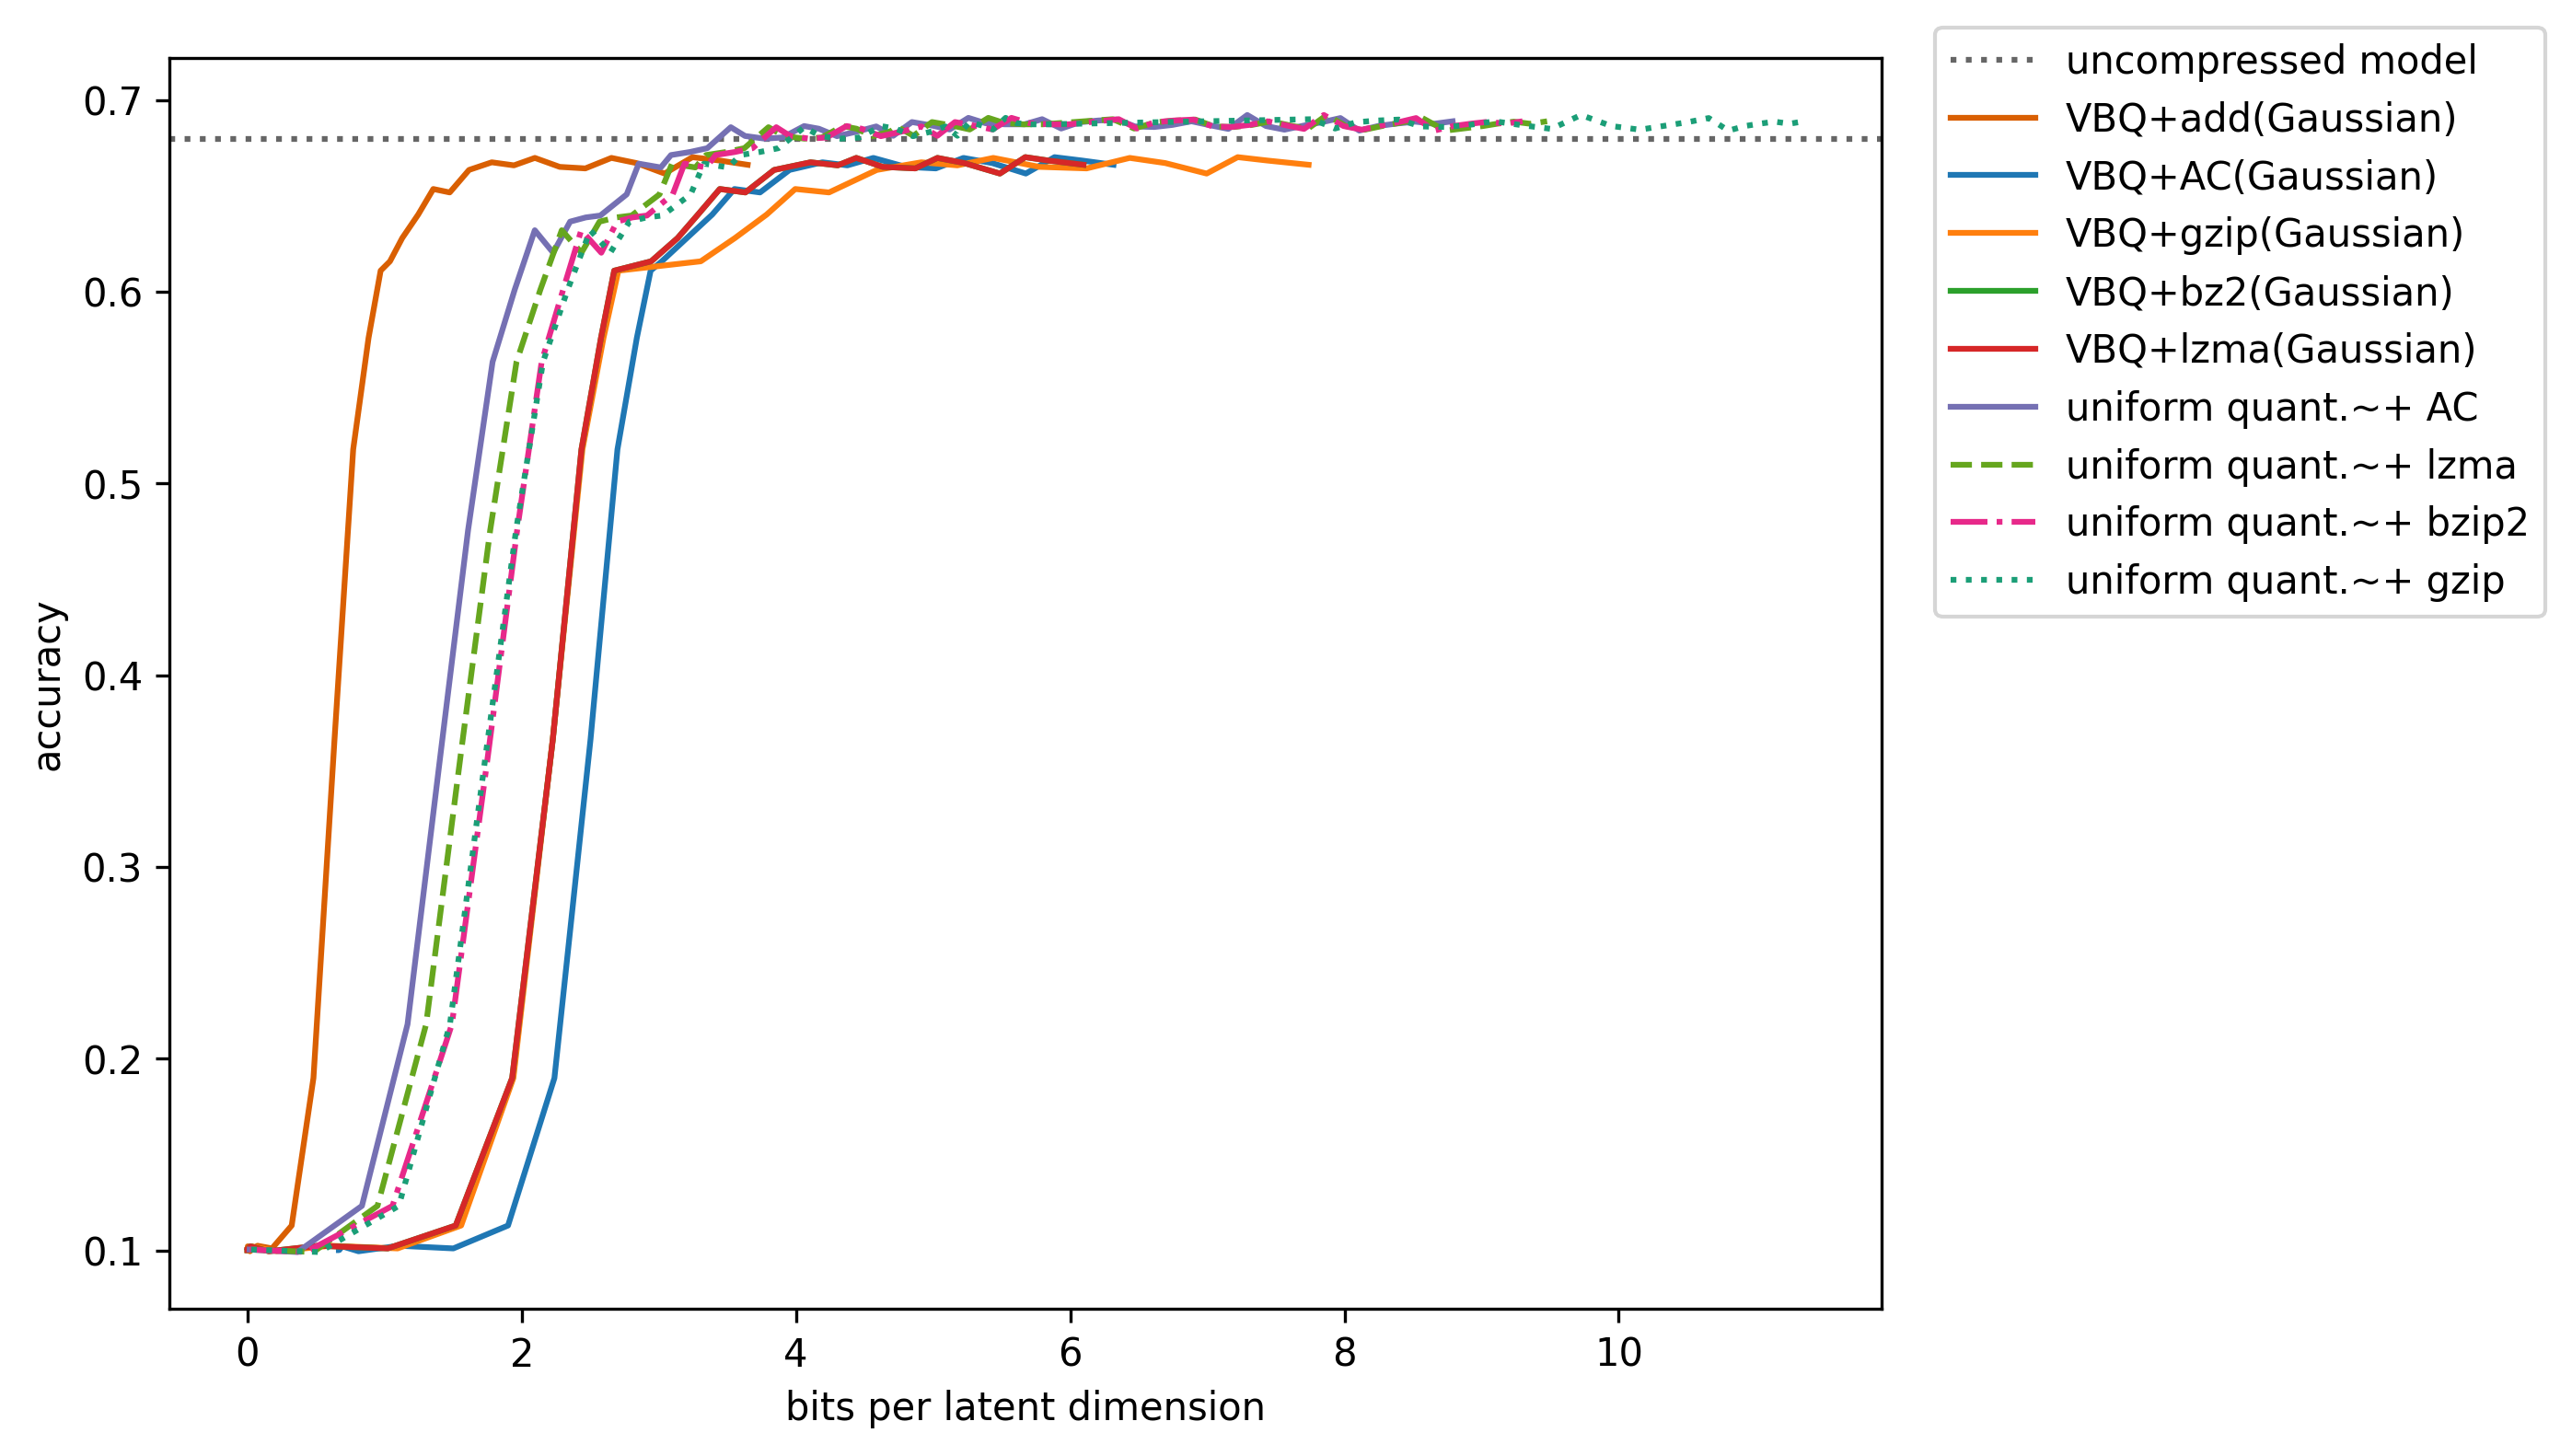

In [23]:
from matplotlib.ticker import AutoMinorLocator
plt.figure(figsize=(8, 6), dpi=300)
# full_acc = diagnostics_uncpr_val['acc']
full_acc = 0.68
plt.axhline(full_acc, linestyle=':', color='#666666', label='uncompressed model')

num_dimensions = len(whole_w)

plt.plot(
    mrrs_and_bitlengths_list[0][:, 5] / num_dimensions,
    mrrs_and_bitlengths_list[0][:, 0],
    '-', label='VBQ+add(Gaussian)', c='#d95f02')

plt.plot(
    mrrs_and_bitlengths_list[0][:, 1] / num_dimensions,
    mrrs_and_bitlengths_list[0][:, 0],
    '-', label='VBQ+AC(Gaussian)')

plt.plot(
    mrrs_and_bitlengths_list[0][:, 2] / num_dimensions,
    mrrs_and_bitlengths_list[0][:, 0],
    '-', label='VBQ+gzip(Gaussian)')

plt.plot(
    mrrs_and_bitlengths_list[0][:, 3] / num_dimensions,
    mrrs_and_bitlengths_list[0][:, 0],
    '-', label='VBQ+bz2(Gaussian)')

plt.plot(
    mrrs_and_bitlengths_list[0][:, 3] / num_dimensions,
    mrrs_and_bitlengths_list[0][:, 0],
    '-', label='VBQ+lzma(Gaussian)')

plt.plot(
    mrrs_and_bitlengths_baseline[:, -4] / num_dimensions,
    mrrs_and_bitlengths_baseline[:, 0],
    '-', label='uniform quant.~+ AC', c='#7570b3')


plt.plot(
    mrrs_and_bitlengths_baseline[:, -1] / num_dimensions,
    mrrs_and_bitlengths_baseline[:, 0],
    '--', label='uniform quant.~+ lzma',  c='#66a61e')

plt.plot(
    mrrs_and_bitlengths_baseline[:, -2] / num_dimensions,
    mrrs_and_bitlengths_baseline[:, 0],
    '-.', label='uniform quant.~+ bzip2',  c='#e7298a')

plt.plot(
    mrrs_and_bitlengths_baseline[:, -3] / num_dimensions,
    mrrs_and_bitlengths_baseline[:, 0],
     ':', label='uniform quant.~+ gzip', c='#1b9e77')

# plt.xlim(-0.2, 10)
plt.xlabel('bits per latent dimension')
plt.ylabel('accuracy')
lgd = plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.04), labelspacing=0.5, handlelength=2.2)
plt.show()